# 🧭 Density-Based Clustering with DBSCAN

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) is a powerful unsupervised clustering algorithm that groups together points that are **densely packed** and labels points in low-density regions as **noise (outliers)**.

Unlike K-Means or hierarchical clustering, **DBSCAN does not require you to specify the number of clusters**. Instead, it discovers clusters based on the idea of **density connectivity**.

---

### 📐 How DBSCAN Works

DBSCAN relies on two key parameters:

- `eps` (ε): The radius that defines the **neighborhood** around a point.
- `min_samples`: The **minimum number of points** required to form a dense region (i.e., a cluster).

Using these parameters, DBSCAN classifies each point into one of three categories:

1. **Core Point**: Has at least `min_samples` points (including itself) within a radius of `eps`.
2. **Border Point**: Has fewer than `min_samples` neighbors, but is **reachable** from a core point.
3. **Noise Point (Outlier)**: Neither a core point nor reachable from one.

---

### 🔗 Density Connectivity

Two points are **density-connected** if:
- One is reachable from the other by a chain of core points,
- Each pair in the chain is within `eps` distance.

Clusters are formed by **chaining together density-connected points**, allowing DBSCAN to discover **non-spherical**, complex-shaped clusters.

---

### ✅ Advantages of DBSCAN

- Does **not** require the number of clusters (`k`) in advance.
- Can detect **arbitrarily shaped** clusters (e.g., spirals, blobs).
- **Robust to outliers** — noise is naturally excluded.
- Works well when clusters have different densities.

---

### ⚠️ Limitations

- Sensitive to the choice of `eps` and `min_samples`.
- Struggles when clusters have **varying densities**.
- Can be computationally expensive for large datasets without indexing structures.

---

In the next section, we’ll use DBSCAN on a synthetic dataset to illustrate how these parameters affect the result, and how DBSCAN behaves differently from centroid-based algorithms like K-Means.



## Demonstration: Hierarchical Clustering on Synthetic Data

We’ll generate a 2D dataset using `make_blobs` with 2 clusters and apply dbscan.

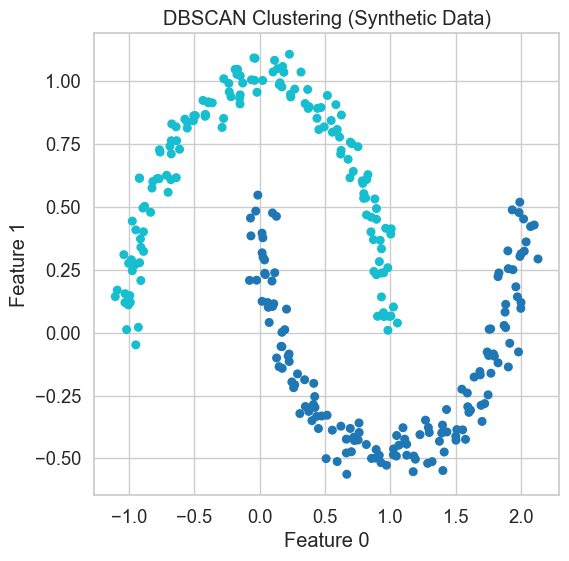

In [65]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Generate dataset with non-globular clusters
X_synth, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# Run DBSCAN
db = DBSCAN(eps=0.3, min_samples=5)
labels = db.fit_predict(X_synth)

# Visualise result
plt.figure(figsize=(6,6))
plt.scatter(X_synth[:, 0], X_synth[:, 1], c=labels, cmap="tab10", s=30)
plt.title("DBSCAN Clustering (Synthetic Data)")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()


## Clustering the Wine Dataset

We now apply DBSCAN to the **Wine dataset**, which includes 13 chemical measurements of wines from 3 grape cultivars.

Unlike K-Means, DBSCAN does not require knowing the number of clusters. Instead, we will tune key hyperparameters like `eps`, `min_samples`, and `metric` to get meaningful clusters.

Let’s first load and inspect the data.


In [56]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load data
wine = load_wine()
X_raw = wine.data
y_true = wine.target
feature_names = wine.feature_names

# Standardise
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Display
df_wine = pd.DataFrame(X_raw, columns=feature_names)
df_wine["Target"] = y_true
df_wine.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### Hyperparameter: `eps` (Epsilon Neighborhood)

The `eps` parameter defines the radius for a point’s neighborhood. A point is considered a **core point** if at least `min_samples` points (including itself) fall within this radius.

- A small `eps` → many points marked as noise
- A large `eps` → clusters merge together

We'll test a range of `eps` values and evaluate clustering quality using the **Silhouette Score**.


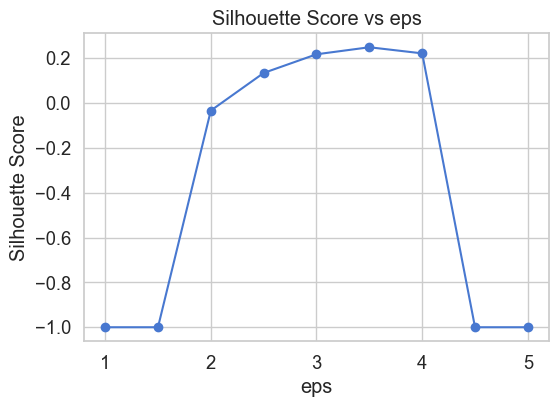

In [57]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = [ 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
scores_eps = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5, metric="euclidean")
    labels = db.fit_predict(X)

    # Only evaluate if at least 2 clusters found
    if len(set(labels)) > 1 and -1 in labels:
        score = silhouette_score(X, labels)
    elif len(set(labels)) > 1:
        score = silhouette_score(X, labels)
    else:
        score = -1

    scores_eps.append((eps, score))

df_eps = pd.DataFrame(scores_eps, columns=["eps", "Silhouette Score"])
df_eps

plt.figure(figsize=(6,4))
plt.plot(df_eps["eps"], df_eps["Silhouette Score"], marker='o')
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs eps")
plt.grid(True)
plt.show()



### Hyperparameter: `min_samples`

The `min_samples` parameter defines the **minimum number of points** required in a neighborhood (within radius `eps`) to consider a point a **core point**.

- Low `min_samples` → more clusters, less noise
- High `min_samples` → fewer clusters, more conservative grouping

We’ll test a range of `min_samples` values with a fixed `ep_


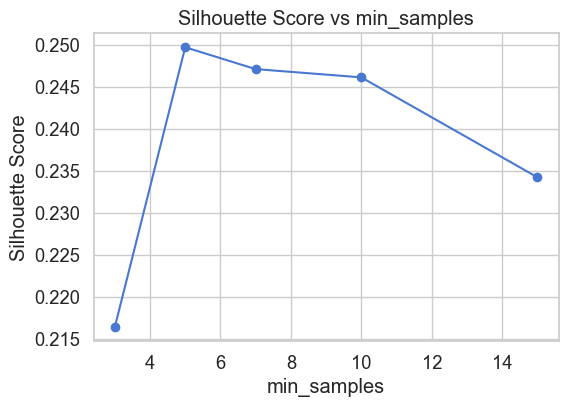

In [58]:
min_samples_vals = [3, 5, 7, 10, 15]
scores_min_samples = []

for m in min_samples_vals:
    db = DBSCAN(eps=3.5, min_samples=m, metric="euclidean")
    labels = db.fit_predict(X)

    if len(set(labels)) > 1 and -1 in labels:
        score = silhouette_score(X, labels)
    elif len(set(labels)) > 1:
        score = silhouette_score(X, labels)
    else:
        score = -1

    scores_min_samples.append((m, score))

df_mins = pd.DataFrame(scores_min_samples, columns=["min_samples", "Silhouette Score"])
df_mins

plt.figure(figsize=(6,4))
plt.plot(df_mins["min_samples"], df_mins["Silhouette Score"], marker='o')
plt.xlabel("min_samples")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs min_samples")
plt.grid(True)
plt.show()


### Hyperparameter: `metric` (Distance Function)

The `metric` parameter defines how distances between points are calculated. This affects how DBSCAN determines which points are close enough to form a cluster.

Common options include:
- `"euclidean"`: straight-line distance (default)
- `"manhattan"`: city-block distance
- `"cosine"`: angular similarity (often used in text embeddings)

Different distance metrics can lead to very different clustering behaviour. We’ll test several using `eps = 0.5` and `min_samples = 5`.


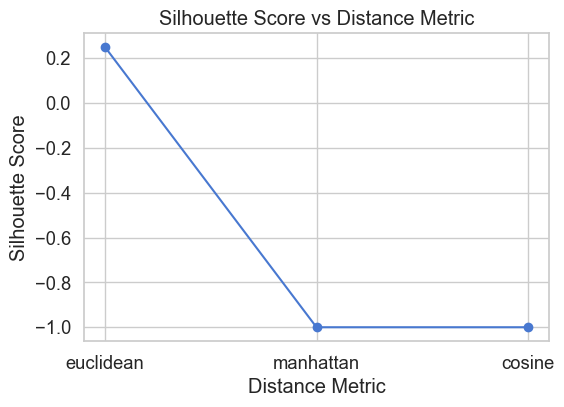

In [59]:
metric_vals = ["euclidean", "manhattan", "cosine"]
scores_metric = []

for metric in metric_vals:
    db = DBSCAN(eps=3.5, min_samples=5, metric=metric)
    labels = db.fit_predict(X)

    if len(set(labels)) > 1 and -1 in labels:
        score = silhouette_score(X, labels)
    elif len(set(labels)) > 1:
        score = silhouette_score(X, labels)
    else:
        score = -1

    scores_metric.append((metric, score))

df_metric = pd.DataFrame(scores_metric, columns=["metric", "Silhouette Score"])
df_metric

plt.figure(figsize=(6,4))
plt.plot(df_metric["metric"], df_metric["Silhouette Score"], marker='o')
plt.xlabel("Distance Metric")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Distance Metric")
plt.grid(True)
plt.show()



### Final DBSCAN Model and Evaluation

Based on our hyperparameter testing, we now run DBSCAN one last time using the best-performing combination.

We will:
- Compute the **Silhouette Score**
- Compare the resulting clusters to the true wine cultivars using a **composition table**


In [62]:
# Best combination based on earlier testing (modify if different in your case)
db_final = DBSCAN(eps=3.5, min_samples=5, metric="euclidean")
final_labels = db_final.fit_predict(X)

# Compute silhouette score
if len(set(final_labels)) > 1:
    sil_score_final = silhouette_score(X, final_labels)
else:
    sil_score_final = -1

print(f"Silhouette Score (final DBSCAN): {sil_score_final:.4f}")
print("Unique labels:", set(final_labels))


Silhouette Score (final DBSCAN): 0.2498
Unique labels: {np.int64(0), np.int64(-1)}


In [63]:
# Create comparison DataFrame
df_result = pd.DataFrame({
    "True Label": y_true,
    "Cluster": final_labels
})

# Crosstab (ignores noise: label -1)
composition = pd.crosstab(df_result["Cluster"], df_result["True Label"],
                          rownames=["Predicted Cluster"], colnames=["True Cultivar"])
composition


True Cultivar,0,1,2
Predicted Cluster,,,
-1,0,6,0
0,59,65,48
